In [ ]:
! pip install wordcloud
! pip install textblob
! pip install gensim
! pip install spacy
! pip install biterm
! pip install corextopic

# Start with loading all necessary libraries
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import string
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from collections import Counter
from itertools import chain
import pprint
from pprint import pprint

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

#pd.set_option('display.max_colwidth', None)
# libraries for visualization
! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in results from Google translation
df_comment_en = pd.read_csv('/project/review_comment_translation.tsv', delimiter='\t', 
                          names=["index", "review_comment_pt", "review_comment_en"])
df_comment_en = df_comment_en.dropna()
df_comment_en = df_comment_en.set_index('index')

# Merge with original notnull review dataset
df_review = pd.read_csv('/project/olist_order_reviews_dataset.csv')
df_full_test = df_review[df_review['review_comment_message'].notna()]
df_trans_review = pd.merge(df_full_test, df_comment_en, left_index=True, right_index=True)
# Remove duplicate column
df_trans_review = df_trans_review.drop('review_comment_message', axis=1)

# Create positive/negative label based on review_score
df_trans_review['label_positive'] = np.where((df_trans_review['review_score'] > 3), 1, 0)
#df_trans_review['label_positive'] = np.where(df_trans_review['review_score'] > 3, 1, 
#                                            (np.where(df_trans_review['review_score'] < 3, -1, 0)))

In [3]:
print('-------word/uppercase character/special character count of review_comment_en--------')
df_trans_review['word_count'] = [len(review.split()) for review in df_trans_review['review_comment_en']]
df_trans_review['uppercase_char_count'] = [sum(char.isupper() for char in review) for review in df_trans_review['review_comment_en']]
df_trans_review['special_char_count'] = [sum(char in string.punctuation for char in review) for review in df_trans_review['review_comment_en']]
#df_p = df_trans_review[['review_comment_en','Word Count', 'Uppercase Char Count', 'Special Char Count']] 
df_trans_review.describe()

-------word/uppercase character/special character count of review_comment_en--------


,review_score,label_positive,word_count,uppercase_char_count,special_char_count
count,41726.000000,41726.000000,41726.000000,41726.000000,41726.000000
mean,3.639817,0.638810,13.042707,3.633202,2.001438
std,1.626590,0.480351,10.844656,12.276240,2.867867
min,1.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,5.000000,1.000000,0.000000
50%,4.000000,1.000000,10.000000,1.000000,1.000000
75%,5.000000,1.000000,18.000000,2.000000,3.000000
max,5.000000,1.000000,55.000000,186.000000,200.000000


In [4]:
df_trans_review['polarity'] = df_trans_review['review_comment_en'].map(lambda text: TextBlob(text).sentiment.polarity)

df_trans_review['review_score'].corr(df_trans_review['polarity'])

0.5533969591452315

## NLP visualization

In [5]:
def getMostCommonWords(reviews, n_most_common, stopwords=None):
    # param reviews: column from pandas.DataFrame (e.g. df['Reviews']) 
        #(pandas.Series)
    # param n_most_common: the top n most common words in reviews (int)
    # param stopwords: list of stopwords (str) to remove from reviews (list)
    # Returns list of n_most_common words organized in tuples as 
        #('term', frequency) (list)

    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove stopwords, if applicable
    if stopwords:
        flattened_reviews = [word for word in flattened_reviews if \
                             word not in stopwords]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)


word_freq = getMostCommonWords(df_trans_review['review_comment_en'], 20, stopwords.words('english'))
list1, list2 = zip(*word_freq)

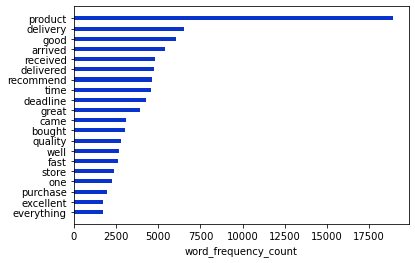

In [6]:
plt.barh(list1, list2, align='center', height=0.4, color = '#0833CD')
plt.gca().invert_yaxis()
#plt.tight_layout()
plt.xlabel('word_frequency_count')
plt.show();

In [7]:
df_trans_review['POS_tag'] = df_trans_review['review_comment_en'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

tokens, tags = zip(*chain(*df_trans_review['POS_tag'].tolist()))
possible_tags = sorted(set(tags))

df_trans_review['pos_counts'] = df_trans_review['POS_tag'].apply(lambda x: Counter(list(zip(*x))[1]))

def add_pos_with_zero_counts(counter, keys_to_add):
    for k in keys_to_add:
        counter[k] = counter.get(k, 0)
    return counter

df_trans_review['pos_counts_with_zero'] = df_trans_review['pos_counts'].apply(lambda x: add_pos_with_zero_counts(x, possible_tags))
df_trans_review['sent_vector'] = df_trans_review['pos_counts_with_zero'].apply(lambda x: [count for tag, count in sorted(x.most_common())])

df2 = pd.DataFrame(df_trans_review['sent_vector'].tolist())
df2.columns = possible_tags

Explanations on pos-tags   https://www.sketchengine.eu/blog/pos-tags/

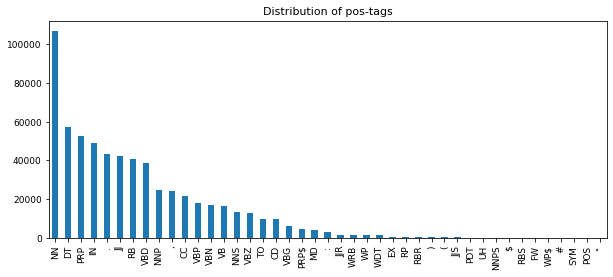

In [8]:
#nltk.help.upenn_tagset()
tags_count = df2.sum(axis = 0, skipna = True) 
tags_count = tags_count.sort_values(ascending=False)
ax = tags_count.plot.bar(figsize=(10,4))
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Distribution of pos-tags', fontsize=11)
plt.savefig('POS.png', dpi=300, bbox_inches='tight');

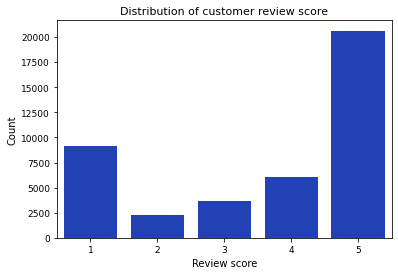

In [9]:
ax=sns.countplot(df_trans_review['review_score'], palette=['#0833CD'])
ax.set_xlabel('Review score', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Distribution of customer review score', fontsize=11)
plt.savefig('review_score.png', dpi=300, bbox_inches='tight');

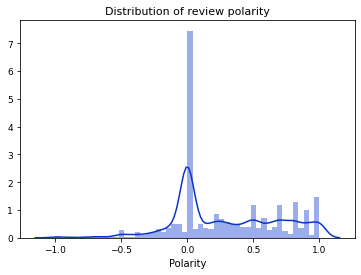

In [10]:
sns.set_palette(sns.color_palette(['#0833CD']))
ax=sns.distplot(df_trans_review['polarity'])
ax.set_xlabel('Polarity', fontsize=10)

ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Distribution of review polarity', fontsize=11)
plt.savefig('review_score_p.png', dpi=300, bbox_inches='tight');

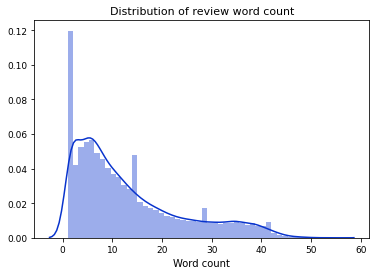

In [11]:
ax=sns.distplot(df_trans_review['word_count'])
ax.set_xlabel('Word count', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Distribution of review word count', fontsize=11)
plt.savefig('review_score_w.png', dpi=300, bbox_inches='tight');

Word cloud tutorial https://www.datacamp.com/community/tutorials/wordcloud-python

## Data preprocessing

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
newStopWords = ['good','great','stark','lannister', 'targaryen','baratheon','tyrell','martell','greyjoy','mormont','blackfyre','tulley','reed','arynn',
                 'clegane','dayne','baelish','umber','hightower','wildling','house selmy','frey','karstark','thenn','bolton','oakheart','tarly',
                 'tarth','payne','swyft','florent','dondarion','blackwater','forrester']
stop_words.extend(newStopWords)

In [6]:
# remove unwanted characters, numbers and symbols
df_trans_review['review_step_1'] = df_trans_review['review_comment_en'].str.replace("[^a-zA-Z#]", " ")



# remove short words (length < 3)
df_trans_review['review_step_2'] = df_trans_review['review_step_1'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# make entire text lowercase
#reviews = [r.lower() for r in reviews]
df_trans_review['review_step_3'] = df_trans_review['review_step_2'].apply(lambda x: ' '.join( [ word.lower() for word in x.split()]))

# remove stopwords from the text
df_trans_review['review_step_4'] = df_trans_review['review_step_3'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


# Lemmazation
lmtzr = WordNetLemmatizer()
df_trans_review['review_step_5'] = df_trans_review['review_step_4'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x.split() ]))


# Tokenization
#df_trans_review['review_step_6'] = df_trans_review['review_step_5'].apply(lambda x: x.split())

reviews = [r.split() for r in df_trans_review['review_step_5']]


## Keyword extraction with Spacy

https://towardsdatascience.com/build-a-keyword-extraction-api-with-spacy-flask-and-fuzzywuzzy-4909d7ffc105

In [6]:
import spacy
nlp=spacy.load('en_core_web_sm')
import subprocess
from string import punctuation
#subprocess.call("python -m spacy download en_core_web_sm",shell=True)

In [7]:
def extract_keywords(nlp, sequence, special_tags : list = None):
    """ Takes a Spacy core language model,
    string sequence of text and optional
    list of special tags as arguments.
    
    If any of the words in the string are 
    in the list of special tags they are immediately 
    added to the result.  
    
    Arguments:
        sequence {str} -- string sequence to have keywords extracted from
    
    Keyword Arguments:
        tags {list} --  list of tags to be automatically added (default: {None})
    
    Returns:
        {list} -- list of the unique keywords extracted from a string
    """    
    result = []

    # custom list of part of speech tags we are interested in
    # we are interested in proper nouns, nouns, and adjectives
    # edit this list of POS tags according to your needs. 
    pos_tag = ['PROPN','NOUN','ADJ','ADV']

    # create a spacy doc object by calling the nlp object on the input sequence
    doc = nlp(sequence.lower())

    # if special tags are given and exist in the input sequence
    # add them to results by default
    if special_tags:
        tags = [tag.lower() for tag in special_tags]
        for token in doc:
            if token.text in tags:
                result.append(token.text)
    
    for chunk in doc.noun_chunks:
        final_chunk = ""
        for token in chunk:
            if (token.pos_ in pos_tag):
                final_chunk =  final_chunk + token.text + " "
        if final_chunk:
            result.append(final_chunk.strip())


    for token in doc:
        if (token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if (token.pos_ in pos_tag):
            result.append(token.text)
    return list(set(result))

# if __name__ == "__main__":
#       """
#       install the langauge model using the subprocess package
#       useful when hosting the service in the cloud as it prevents against
#       us forgetting to do this via the CLI
#       """
#     subprocess.call("python -m spacy download en_core_web_sm",shell=True)

  # load the small english language model, 
    nlp = spacy.load("en_core_web_sm")

    print("Loaded language vocabulary")
    print(extract_keywords(nlp,"""Learning how to use natural language
   processing in python and build Flask API's is easy when you have packages like spacy and fuzzywuzzy"""))

In [8]:
df_trans_review['a'] = df_trans_review['review_step_1'].apply(lambda x: extract_keywords(nlp, x ,special_tags  = None))

In [9]:
#pd.set_option('display.max_colwidth', None)
df_p=df_trans_review[['review_comment_en','a']]

from collections import OrderedDict
df_p['keyword'] = [' '.join(map(str, l)) for l in df_p['a']]
df_p['keyword_single'] = (df_p['keyword'].str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
df_p.to_csv("keyword_extraction_with_adv.csv", header=True, index=False )

In [27]:
df_keyword = pd.read_csv('/project/keyword_extraction_with_adv.csv')
df_keyword.dropna(inplace=True)

In [29]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
newStopWords = ['good','great','stark','lannister', 'targaryen','baratheon','tyrell','martell','greyjoy','mormont','blackfyre','tulley','reed','arynn',
                 'clegane','dayne','baelish','umber','hightower','wildling','house selmy','frey','karstark','thenn','bolton','oakheart','tarly',
                 'tarth','payne','swyft','florent','dondarion','blackwater','forrester']
stop_words.extend(newStopWords)

# remove stopwords from the text
df_keyword['keyword_1'] = df_keyword['keyword_single'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Lemmazation
lmtzr = WordNetLemmatizer()
df_keyword['keyword_2'] = df_keyword['keyword_1'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x.split() ]))

In [30]:
text_keyword = " ".join(review for review in df_keyword['keyword_2'])
print ("There are {} words in the combination of all customer reviews.".format(len(text_keyword)))

There are 1107379 words in the combination of all customer reviews.


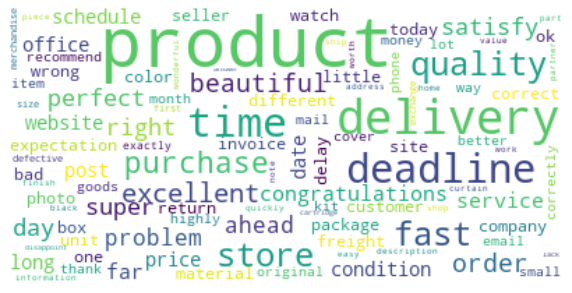

In [31]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42,
                          collocations=False
                         ).generate(text_keyword)
#print(wordcloud)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("cloud_all.png", dpi=500);
plt.show();

In [32]:
text_full = " ".join(review for review in df_trans_review['review_step_5'])
print ("There are {} words in the combination of all customer reviews.".format(len(text_full)))

There are 1805263 words in the combination of all customer reviews.


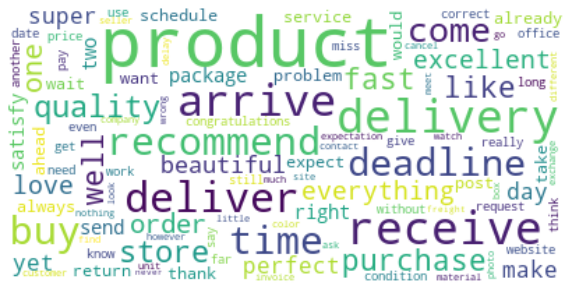

In [33]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42,
                          collocations=False
                         ).generate(text_full)
#print(wordcloud)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("cloud_all.png", dpi=500);
plt.show();

## Modeling

### NMF Topic extraction with TF-IDF

https://shravan-kuchkula.github.io/topic-modeling/#build-lda-model-using-sklearn

https://www.kaggle.com/akashram/topic-modeling-intro-implementation

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(min_df = 2) #custom_stop_words
A = vectorizer.fit_transform(df_trans_review['review_step_5'])
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 41726 X 3966 TF-IDF-normalized document-term matrix


In [7]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 3966 distinct terms


In [8]:
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [9]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [10]:
import gensim
docgen = TokenGenerator(df_trans_review['review_step_5'], stop_words)
w2v_model = gensim.models.Word2Vec(docgen, size=3966, min_count=2, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [11]:
from sklearn import decomposition
topic_models = []
ks=[3,5,8,10,15,20]
# try each value of k
for k in ks:
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=3 ...
Applying NMF for k=5 ...
Applying NMF for k=8 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


Once we have our Word2vec model, we can use it as part of our topic coherence approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows

In [12]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [ ]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

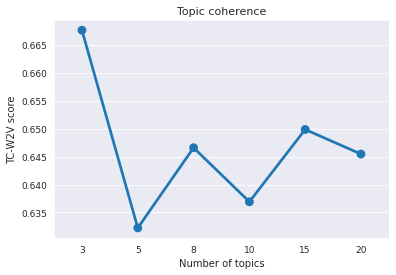

In [14]:
#sns.set_palette(sns.color_palette(['#0833CD']))
plotData = pd.DataFrame({'Number of topics':k_values,
                         'Coherence score_cv':coherences})
# f,ax = plt.subplots(figsize=(6,4))
sns.set_style("darkgrid")
ax = sns.pointplot(x='Number of topics',y= 'Coherence score_cv',data=plotData)
ax.set_xlabel('Number of topics', fontsize=10)
ax.set_ylabel('TC-W2V score', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Topic coherence', fontsize=11)
plt.savefig('coherence_NMF.png', dpi=300);

The best score appears when k=3.

In [26]:
# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])

    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]

    return topics


# prints components of all the topics
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

# prints components of all the topics
# obtained from topic modeling
def get_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     num_terms=None):

    topic_terms = []

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        topic_terms.append(topic[:num_terms] if num_terms else topic)

    return topic_terms

def getTermsAndSizes(topic_display_list_item):
    terms = []
    sizes = []
    for term, size in topic_display_list_item:
        terms.append(term)
        sizes.append(size)
    return terms, sizes

In [30]:
# for LDA
# from sklearn.feature_extraction.text import CountVectorizer

# for NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize the corpus
#count_vectorizer = CountVectorizer(min_df = 2, max_df=0.95, ngram_range=(1,1))
tfidf_vectorizer = TfidfVectorizer(min_df = 2, max_df=0.95, ngram_range=(1,1))

# calculate the feature matrix
#feature_matrix = count_vectorizer.fit_transform(df_trans_review['review_step_5'])
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(df_trans_review['review_step_5'])

#display(tfidf_feature_matrix.shape)
display(tfidf_feature_matrix.shape)

# Materialize the sparse data
data_dense = tfidf_feature_matrix.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


from sklearn.decomposition import NMF

nmf = NMF(n_components=3, random_state=43,  alpha=0.1, l1_ratio=0.5)
nmf_output = nmf.fit_transform(tfidf_feature_matrix)

nmf_feature_names = tfidf_vectorizer.get_feature_names()
nmf_weights = nmf.components_

topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)
print_topics_udf(topics, total_topics=3, num_terms=20, display_weights=True)

(41726, 3966)

Sparsicity:  0.14618457144560185 %
Topic #1 with weights
[('product', 12.32), ('deliver', 4.44), ('arrive', 4.4), ('deadline', 4.39), ('receive', 3.87), ('time', 3.29), ('quality', 2.33), ('well', 1.83), ('excellent', 1.56), ('like', 1.12), ('buy', 1.11), ('yet', 1.07), ('love', 1.06), ('come', 0.99), ('perfect', 0.99), ('condition', 0.82), ('satisfy', 0.77), ('package', 0.76), ('schedule', 0.76), ('order', 0.76)]
Topic #2 with weights
[('recommend', 11.93), ('store', 1.22), ('super', 1.19), ('everyone', 0.8), ('highly', 0.75), ('deadline', 0.57), ('love', 0.46), ('well', 0.32), ('excellent', 0.28), ('seller', 0.28), ('arrive', 0.26), ('buy', 0.26), ('everything', 0.25), ('always', 0.22), ('beautiful', 0.22), ('like', 0.21), ('right', 0.2), ('quality', 0.16), ('service', 0.16), ('yes', 0.13)]
Topic #3 with weights
[('delivery', 9.12), ('fast', 8.14), ('super', 2.08), ('time', 1.89), ('ahead', 0.85), ('quality', 0.83), ('excellent', 0.67), ('congratulations', 0.54), ('satisfy', 0.5), ('

In [31]:
topics_display_list = get_topics_udf(topics, total_topics=3, num_terms=20)

In [32]:
a = pd.DataFrame(topics_display_list)

In [33]:
b=a.T
b.to_csv("NMF_results.csv", index=False )

In [34]:
df_trans_review['Topic_nmf'] = nmf_output.argmax(axis=1)

df_trans_review['Topic_nmf'].value_counts()

0    30268
2     6563
1     4895
Name: Topic_nmf, dtype: int64

In [35]:
df_trans_review.to_csv("NMF_topic_label.csv", index=False )

In [ ]:
# terms, sizes = getTermsAndSizes(topics_display_list[0])

# num_top_words = 15
# fontsize_base = 15 / np.max(sizes) # font size for word with largest share in corpus

# num_topics = 1

# for t in range(num_topics):
#     fig, ax = plt.subplots(1, num_topics, figsize=(6, 12))
#     plt.ylim(0, num_top_words + 1.0)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('Topic #{}'.format(t))

#     for i, (word, share) in enumerate(zip(terms, sizes)):
#         word = word + " (" + str(share) + ")"
#         plt.text(0.3, num_top_words-i-1.0, word, fontsize=fontsize_base*share)

# plt.tight_layout();

### GENSIM LDA   https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

https://www.os3.nl/_media/2017-2018/courses/rp2/p76_report.pdf

In [23]:
reviews=[r.split() for r in df_trans_review['review_step_5']]

dictionary = corpora.Dictionary(reviews)

#doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews]

# Filter out words that occur less than 10 documents, or more than 50% of the documents
## dictionary.filter_extremes(no_above=5)

# Create Bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(rev) for rev in reviews]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(bow_corpus))


# Creating the object for LDA model using gensim library
# LDA = gensim.models.ldamodel.LdaModel

Number of unique tokens: 7492
Number of documents: 41726


### U_mass coherence

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
from tqdm import tqdm
coherenceList_cv=[]
num_topics_list = [3,5, 8,10,15]
for num_topics in tqdm(num_topics_list):
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       alpha=0.5, 
                                       id2word=dictionary,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=10000,
                                       passes=30,
                                       workers=4
                                       #per_word_topics=True
                                      )
    texts = [[dictionary[word_id] for word_id, freq in doc] for doc in bow_corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    coherenceList_cv.append(coherence_lda)
print('\nCoherence Score: ', coherence_lda)

In [ ]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'Coherence score_cv':coherenceList_cv})
# f,ax = plt.subplots(figsize=(6,4))
# sns.set_style("darkgrid")
ax = sns.pointplot(x='Number of topics',y= 'Coherence score_cv',data=plotData)
ax.set_xlabel('Number of topics', fontsize=10)
ax.set_ylabel('U_Mass score', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Topic coherence', fontsize=11)
plt.savefig('coherence_umass.png', dpi=300);

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=10000,
                                           passes=30,
                                           alpha=a,
                                           eta=b,
                                           workers=4)
    texts = [[dictionary[word_id] for word_id, freq in doc] for doc in bow_corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [ ]:
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

for a in alpha:
    for b in beta:
        cv = compute_coherence_values(corpus=bow_corpus, dictionary=dictionary, k=5, a=a, b=b)
        model_results['Topics'].append(k)
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(cv)
                    
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)

### C_v coherence

In [73]:
from gensim.models import CoherenceModel
# Compute Coherence Score
from tqdm import tqdm
coherenceList_cv=[]
num_topics_list = [3,5, 8,10,15]
for num_topics in tqdm(num_topics_list):
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       alpha=0.5, 
                                       id2word=dictionary,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=10000,
                                       passes=30,
                                       workers=4
                                       #per_word_topics=True
                                      )
    texts = [[dictionary[word_id] for word_id, freq in doc] for doc in bow_corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherenceList_cv.append(coherence_lda)
print('\nCoherence Score: ', coherence_lda)


100%|██████████| 5/5 [12:16<00:00, 147.35s/it]


Coherence Score:  0.37048054594635427


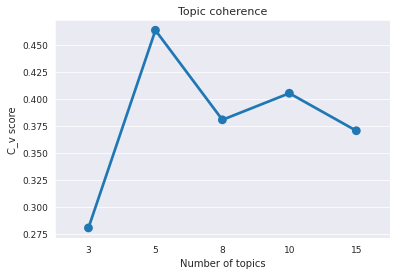

In [74]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'Coherence score_cv':coherenceList_cv})
# f,ax = plt.subplots(figsize=(6,4))
# sns.set_style("darkgrid")
ax = sns.pointplot(x='Number of topics',y= 'Coherence score_cv',data=plotData)
ax.set_xlabel('Number of topics', fontsize=10)
ax.set_ylabel('C_v score', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Topic coherence', fontsize=11)
plt.savefig('coherence_cv.png', dpi=300);

In [75]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=10000,
                                           passes=30,
                                           alpha=a,
                                           eta=b,
                                           workers=4)
    texts = [[dictionary[word_id] for word_id, freq in doc] for doc in bow_corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

alpha=[0.3,0.5,0.7]
beta=[0.3,0.5,0.7]

model_results = {
                # 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

for a in alpha:
    for b in beta:
        cv = compute_coherence_values(corpus=bow_corpus, dictionary=dictionary, k= 5, a=a, b=b)
        #model_results['Topics'].append(k)
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(cv)
                    
pd.DataFrame(model_results).to_csv('lda_tuning_results_cv.csv', index=False)

In [78]:
# Creating the object for LDA model using gensim library

lda_model_5 = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       alpha=0.5, 
                                       eta=0.7, 
                                       id2word=dictionary,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=10000,
                                       passes=30,
                                       workers=4
                                       #per_word_topics=True
                                      )


pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(lda_model_5, bow_corpus, dictionary)


pyLDAvis.save_html(vis_5, 'lda_5.html')

In [79]:
# Build LDA model
# lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
#                                        id2word=dictionary,
#                                        num_topics=5, 
#                                        random_state=100,
#                                        chunksize=1000,
#                                        passes=50,
#                                        workers=3)
#                                        #per_word_topics=True)

from pprint import pprint
# Print the Keyword in the 5 topics
pprint(lda_model_5.print_topics())
doc_lda = lda_model_5[bow_corpus]

lda_df = lda_model_5.get_document_topics(bow_corpus,minimum_probability=0)
lda_df = pd.DataFrame(list(lda_df))

num_topics = lda_model_5.num_topics

lda_df.columns = ['Topic'+str(i) for i in range(num_topics)]
for i in range(len(lda_df.columns)):
    lda_df.iloc[:,i]=lda_df.iloc[:,i].apply(lambda x: x[1])
lda_df['Automated_topic_id'] =lda_df.apply(lambda x: np.argmax(x),axis=1)
lda_df.head()

[(0,
  '0.088*"recommend" + 0.077*"product" + 0.072*"delivery" + 0.050*"fast" + '
  '0.035*"excellent" + 0.034*"love" + 0.027*"super" + 0.026*"satisfy" + '
  '0.024*"right" + 0.023*"schedule"'),
 (1,
  '0.100*"arrive" + 0.085*"product" + 0.077*"deadline" + 0.073*"time" + '
  '0.051*"deliver" + 0.045*"store" + 0.037*"well" + 0.035*"buy" + '
  '0.029*"everything" + 0.025*"perfect"'),
 (2,
  '0.090*"product" + 0.035*"quality" + 0.035*"come" + 0.016*"expect" + '
  '0.015*"like" + 0.014*"work" + 0.014*"use" + 0.012*"without" + '
  '0.009*"beautiful" + 0.009*"color"'),
 (3,
  '0.074*"product" + 0.069*"receive" + 0.036*"deliver" + 0.032*"purchase" + '
  '0.031*"delivery" + 0.021*"yet" + 0.016*"post" + 0.014*"make" + '
  '0.013*"office" + 0.012*"days"'),
 (4,
  '0.043*"buy" + 0.036*"one" + 0.035*"receive" + 0.029*"come" + 0.023*"order" '
  '+ 0.019*"send" + 0.019*"two" + 0.016*"product" + 0.015*"return" + '
  '0.011*"miss"')]


,Topic0,Topic1,Topic2,Topic3,Topic4,Automated_topic_id
0,0.095877,0.463396,0.091257,0.238931,0.110539,1
1,0.623490,0.253104,0.040673,0.042113,0.040619,0
2,0.088700,0.126581,0.198503,0.145946,0.440270,4
3,0.079163,0.080825,0.281181,0.079545,0.479287,4
4,0.355590,0.429234,0.071389,0.074910,0.068876,1


In [24]:
# Creating the object for LDA model using gensim library

lda_model_5 = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       alpha=0.3, 
                                       eta=0.5, 
                                       id2word=dictionary,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=10000,
                                       passes=30,
                                       workers=4
                                       #per_word_topics=True
                                      )


pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(lda_model_5, bow_corpus, dictionary)


pyLDAvis.save_html(vis_5, 'lda_5_0.3_0.5.html')

## Biterm Topic Modeling

https://github.com/markoarnauto/biterm

In [20]:
from biterm.btm import oBTM 
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms, topic_summuary # helper functions

if __name__ == "__main__":

    # texts = open('./data/reuters.titles').read().splitlines() # path of data file

    # vectorize texts
    vec = CountVectorizer(stop_words='english')
    X = vec.fit_transform(df_trans_review['review_step_5']).toarray()

    # get vocabulary
    vocab = np.array(vec.get_feature_names())

    # get biterms
    biterms = vec_to_biterms(X)

    # create btm
    btm = oBTM(num_topics=3, V=vocab)

    print("\n\n Train Online BTM ..")
    for i in range(0, len(biterms), 10000): # prozess chunk of 200 texts
        biterms_chunk = biterms[i:i + 10000]
        btm.fit(biterms_chunk, iterations=15)
    topics = btm.transform(biterms)

#     print("\n\n Visualize Topics ..")
#     vis = pyLDAvis.prepare(btm.phi_wz.T, topics, np.count_nonzero(X, axis=1), vocab, np.sum(X, axis=0))
#     pyLDAvis.save_html(vis, './online_btm.html')  # path to output

    print("\n\n Topic coherence ..")
    topic_summuary(btm.phi_wz.T, X, vocab, 20)

#     print("\n\n Texts & Topics ..")
#     for i in range(len(texts)):
#         print("{} (topic: {})".format(texts[i], topics[i].argmax()))



 Train Online BTM ..


100%|██████████| 15/15 [02:16<00:00,  9.10s/it]
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/biterm/btm.py:76: RuntimeWarning: invalid value encountered in true_divide
  P_zd[i] = P_zb.sum(axis=0) / P_zb.sum(axis=0).sum()




 Topic coherence ..
Topic 0 | Coherence=-548.36 | Top words= product receive buy deliver purchase order come delivery post arrive time store pay office make wait return send far want
Topic 1 | Coherence=-577.41 | Top words= product come buy receive like arrive deliver time quality purchase make order send package use delivery return work store color
Topic 2 | Coherence=-541.13 | Top words= product delivery arrive recommend deadline time deliver quality fast store buy receive excellent love super like perfect purchase beautiful schedule


{'coherence': [-548.3645777959393, -577.4103538310649, -541.129175977066],
 'top_words': [array(['product', 'receive', 'buy', 'deliver', 'purchase', 'order',
         'come', 'delivery', 'post', 'arrive', 'time', 'store', 'pay',
         'office', 'make', 'wait', 'return', 'send', 'far', 'want'],
        dtype='<U246'),
  array(['product', 'come', 'buy', 'receive', 'like', 'arrive', 'deliver',
         'time', 'quality', 'purchase', 'make', 'order', 'send', 'package',
         'use', 'delivery', 'return', 'work', 'store', 'color'],
        dtype='<U246'),
  array(['product', 'delivery', 'arrive', 'recommend', 'deadline', 'time',
         'deliver', 'quality', 'fast', 'store', 'buy', 'receive',
         'excellent', 'love', 'super', 'like', 'perfect', 'purchase',
         'beautiful', 'schedule'], dtype='<U246')]}

In [87]:
print("\n\n Topic coherence ..")
topic_summuary(btm.phi_wz.T, X, vocab, 15)



 Topic coherence ..
Topic 0 | Coherence=-286.02 | Top words= product come receive buy order deliver return arrive send like purchase make wrong quality delivery
Topic 1 | Coherence=-272.26 | Top words= product come buy receive arrive deliver time like delivery beautiful order quality store recommend purchase
Topic 2 | Coherence=-276.73 | Top words= product delivery arrive recommend deadline time deliver fast quality store excellent buy super perfect love
Topic 3 | Coherence=-286.68 | Top words= product receive deliver buy purchase delivery order post time store arrive office pay wait make
Topic 4 | Coherence=-289.99 | Top words= product come receive buy like deliver arrive delivery time purchase make quality recommend use send


{'coherence': [-286.02047976857284,
  -272.25916579291345,
  -276.7300662298519,
  -286.681243932079,
  -289.98987373379134],
 'top_words': [array(['product', 'come', 'receive', 'buy', 'order', 'deliver', 'return',
         'arrive', 'send', 'like', 'purchase', 'make', 'wrong', 'quality',
         'delivery'], dtype='<U246'),
  array(['product', 'come', 'buy', 'receive', 'arrive', 'deliver', 'time',
         'like', 'delivery', 'beautiful', 'order', 'quality', 'store',
         'recommend', 'purchase'], dtype='<U246'),
  array(['product', 'delivery', 'arrive', 'recommend', 'deadline', 'time',
         'deliver', 'fast', 'quality', 'store', 'excellent', 'buy', 'super',
         'perfect', 'love'], dtype='<U246'),
  array(['product', 'receive', 'deliver', 'buy', 'purchase', 'delivery',
         'order', 'post', 'time', 'store', 'arrive', 'office', 'pay',
         'wait', 'make'], dtype='<U246'),
  array(['product', 'come', 'receive', 'buy', 'like', 'deliver', 'arrive',
         'delivery

In [88]:
print("\n\n Topic coherence ..")
topic_summuary(btm.phi_wz.T, X, vocab, 10)



 Topic coherence ..
Topic 0 | Coherence=-116.79 | Top words= product come receive buy order deliver return arrive send like
Topic 1 | Coherence=-112.95 | Top words= product come buy receive arrive deliver time like delivery beautiful
Topic 2 | Coherence=-104.82 | Top words= product delivery arrive recommend deadline time deliver fast quality store
Topic 3 | Coherence=-110.07 | Top words= product receive deliver buy purchase delivery order post time store
Topic 4 | Coherence=-102.14 | Top words= product come receive buy like deliver arrive delivery time purchase


{'coherence': [-116.7901354643576,
  -112.95125529674937,
  -104.82064766602595,
  -110.0705488327038,
  -102.14016306902381],
 'top_words': [array(['product', 'come', 'receive', 'buy', 'order', 'deliver', 'return',
         'arrive', 'send', 'like'], dtype='<U246'),
  array(['product', 'come', 'buy', 'receive', 'arrive', 'deliver', 'time',
         'like', 'delivery', 'beautiful'], dtype='<U246'),
  array(['product', 'delivery', 'arrive', 'recommend', 'deadline', 'time',
         'deliver', 'fast', 'quality', 'store'], dtype='<U246'),
  array(['product', 'receive', 'deliver', 'buy', 'purchase', 'delivery',
         'order', 'post', 'time', 'store'], dtype='<U246'),
  array(['product', 'come', 'receive', 'buy', 'like', 'deliver', 'arrive',
         'delivery', 'time', 'purchase'], dtype='<U246')]}

In [123]:
df_topic=pd.DataFrame(topics)
df_topic['Automated_topic_id'] =df_topic.apply(lambda x: np.argmax(x),axis=1)
df_topic.to_csv('/project/BTM_predict topics.csv',index=False)

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.402.4032&rep=rep1&type=pdf

## Bigram/Trigram LDA

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [7]:
review_1 = [r.split() for r in df_trans_review['review_step_3']]

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(reviews, min_count=1, threshold=2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[review_1], threshold=2)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[review_1[790]]])

['loved', 'the', 'product', 'arrived_before', 'the_deadline']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(review_1)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['receive', 'well_deadline']]


In [ ]:
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=15, 
#                                            random_state=10000,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

In [ ]:
# # Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [89]:
from tqdm import tqdm
coherenceList_cv=[]
num_topics_list = [3,5,10,15,18]
for num_topics in tqdm(num_topics_list):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=102,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    texts = [[id2word[word_id] for word_id, freq in doc] for doc in corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherenceList_cv.append(coherence_lda)
print('\nCoherence Score: ', coherence_lda)


100%|██████████| 5/5 [07:47<00:00, 93.49s/it]


Coherence Score:  0.2898929398384744


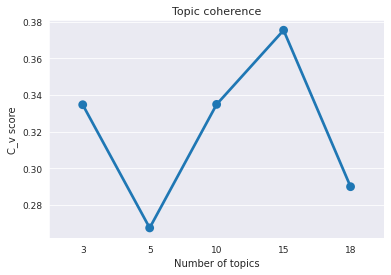

In [91]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'Coherence score_cv':coherenceList_cv})
# f,ax = plt.subplots(figsize=(6,4))
sns.set_style("darkgrid")
ax = sns.pointplot(x='Number of topics',y= 'Coherence score_cv',data=plotData)
ax.set_xlabel('Number of topics', fontsize=10)
ax.set_ylabel('C_v score', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Topic coherence', fontsize=11)
plt.savefig('coherence_bigram.png', dpi=300);

In [92]:
from tqdm import tqdm
coherenceList_cv=[]
num_topics_list = [3,5,10,15,18]
for num_topics in tqdm(num_topics_list):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=102,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    texts = [[id2word[word_id] for word_id, freq in doc] for doc in corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    coherenceList_cv.append(coherence_lda)
print('\nCoherence Score: ', coherence_lda)


100%|██████████| 5/5 [07:40<00:00, 92.09s/it]


Coherence Score:  -7.7317109924697025


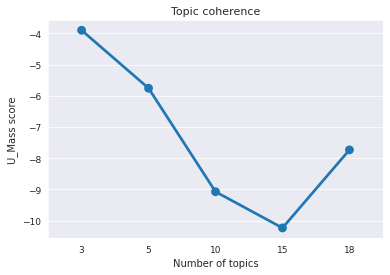

In [94]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'Coherence score_cv':coherenceList_cv})
# f,ax = plt.subplots(figsize=(6,4))
sns.set_style("darkgrid")
ax = sns.pointplot(x='Number of topics',y= 'Coherence score_cv',data=plotData)
ax.set_xlabel('Number of topics', fontsize=10)
ax.set_ylabel('U_Mass score', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.title('Topic coherence', fontsize=11)
plt.savefig('coherence_bigram_umass.png', dpi=300);

In [15]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=10000,
                                           passes=30,
                                           alpha=a,
                                           eta=b,
                                           workers=4)
    #texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus]
    #coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [17]:
alpha=[0.3,0.5,0.7]
beta=[0.3,0.5,0.7]

model_results = {
                # 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

for a in alpha:
    for b in beta:
        cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k= 15, a=a, b=b)
        #model_results['Topics'].append(k)
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(cv)
                    
pd.DataFrame(model_results).to_csv('Bigram_lda_tuning_results_cv.csv', index=False)

In [18]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

lda_model_15 = LDA(corpus=corpus, id2word=id2word, num_topics=15, random_state=100, alpha=0.3,
                                           eta=0.7,chunksize=10000, passes=30)

pyLDAvis.enable_notebook()
vis_15 = pyLDAvis.gensim.prepare(lda_model_15, corpus, id2word)


pyLDAvis.save_html(vis_15, 'lda_15.html')

In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=10000,
                                           passes=30,
                                           alpha=a,
                                           eta=b,
                                           workers=4)
    #texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus]
    #coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='u_mass')
    return coherence_model_lda.get_coherence()

In [20]:
alpha=[0.3,0.5,0.7]
beta=[0.3,0.5,0.7]

model_results = {
                # 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

for a in alpha:
    for b in beta:
        cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k= 3, a=a, b=b)
        #model_results['Topics'].append(k)
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(cv)
                    
pd.DataFrame(model_results).to_csv('Bigram_lda_tuning_results_umass.csv', index=False)

In [21]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

lda_model_3 = LDA(corpus=corpus, id2word=id2word, num_topics=3, random_state=100, alpha=0.7,
                                           eta=0.7,chunksize=10000, passes=30)

pyLDAvis.enable_notebook()
vis_3 = pyLDAvis.gensim.prepare(lda_model_3, corpus, id2word)


pyLDAvis.save_html(vis_3, 'lda_3.html')

## Anchoring Topic Modeling with CorEx

In [157]:
import scipy.sparse as ss
import matplotlib.pyplot as plt

from corextopic import corextopic as ct
from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=.9, min_df=2, binary=True)
doc_word = vectorizer.fit_transform(df_trans_review['review_step_5'])
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words
words = list(np.asarray(vectorizer.get_feature_names()))

(41726, 3966)

In [161]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=30, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words)
print(topic_model.tc);

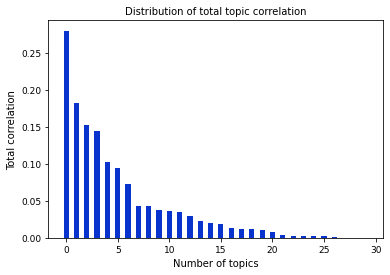

In [167]:
plt.figure(figsize=(6,4))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#0833CD', width=0.5, align='center')
plt.xlabel('Number of topics', fontsize=10)
plt.ylabel('Total correlation', fontsize=10)
plt.title('Distribution of total topic correlation', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=9);
plt.savefig('topic_selection.png', dpi=300, bbox_inches='tight');

https://gist.github.com/patrickvankessel/0d5bd690910edece831dbdf32fb2fb2d

In [196]:
import scipy.sparse as ss
from corextopic import corextopic as ct


from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    max_df=.9,
    min_df=2,
    max_features=None
)
#vectorizer = vectorizer.fit(df_trans_review['review_step_5'])
tfidf = vectorizer.fit_transform(df_trans_review['review_step_5'])
vocab = vectorizer.get_feature_names()
print(len(vocab))

3966


https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb

#### Anchoring with single words

In [169]:
#df_0=df.loc[df['topic_coverage'] == 0]
#df_0.tail(30)

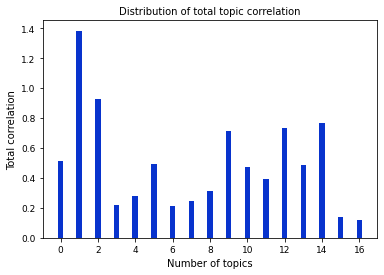

In [202]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [
    [ "quality"],
    ['product'],
    ['expection'],
    ["delivery"],
    [ "service"],
    ['satisfy'],
    ['store'],
 #   ["recommend", "good"],
    ['price'],
    ['thank'],
   # ['value'],
    ['problem'],
    ['deadline'],
    ['return'],
    #['delay'],
    ['package'],
    ['time'],
   # ['terrible'],
    ['purchase'],
    ['recommend'],
    ['good']
   # ['recommend','good', 'perfect'],
    
]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=17, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=3 # Tell the model how much it should rely on the anchors
)
#print(model.tc)
plt.figure(figsize=(6,4))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#0833CD', width=0.3)

plt.tick_params(axis='both', which='major', labelsize=9)
plt.title('Distribution of total topic correlation', fontsize=10)
plt.xlabel('Number of topics', fontsize=10)
plt.ylabel('Total correlation', fontsize=10)
plt.savefig('17_anchor.png', dpi=300, bbox_inches='tight');

In [191]:
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["topic_{}".format(i+1) for i in range(17)]
).astype(float)
topic_df.index = df_trans_review.index
df = pd.concat([df_trans_review, topic_df], axis=1)
df['topic_coverage']=df['topic_1']+df['topic_2']+df['topic_3']+df['topic_4']+df['topic_5']+df['topic_6']+df['topic_7']+df['topic_8']+df['topic_9']+df['topic_10']+df['topic_11']+df['topic_12']+df['topic_13']+df['topic_14']+df['topic_15']+df['topic_16']+df['topic_17']
df['topic_coverage'].value_counts()

1.0    10283
2.0    10272
0.0     7284
3.0     7006
4.0     4032
5.0     1955
6.0      696
7.0      164
8.0       30
9.0        4
Name: topic_coverage, dtype: int64

In [192]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=20)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: quality, poor, excellent, low, high, chinese, workmanship, optimal, puppies, bake, wrench, silk, bass, fuse, intermediate, highest, unravel, wind, utensils, padlock
Topic #2: product, advertise, condition, correct, describe, expect, exactly, correctly, match, specifications, correspond, characteristics, gorgeous, accord, accordance, announcement, specify, feature
Topic #3: delivery, fast, delay, ahead, schedule, speed, date, efficient, faster, early, quick, agility, agile, anticipate, man, slow, allege, punctual, mega, compliment
Topic #4: service, provide, provision, level, prompt, lousy, ameiiiiiiii, vip, amaricanas, excellence, accurate, performance, impeccable, professionals, promptly, tag, shelter, accommodate, adorooo, predict
Topic #5: satisfy, fully, acquisition, reservation, invicta, till, hyper, usual, linda, tenant, spell, brigade, cascade, ergonomic, knee, unreliable, incredibly, obgd, insecure, copra
Topic #6: store, shop, online, trust, american, physical, best,

#### Two or more words

In [193]:
# df_0=df.loc[df['topic_coverage'] == 0]
# df_0.sample(30)

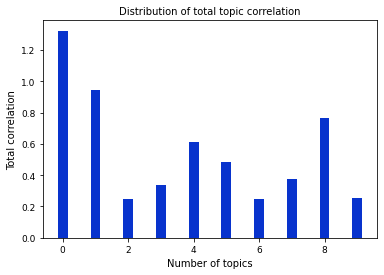

In [211]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [
    ["product", "quality"],
    ["delivery",'time'],
    [ "service",'seller'],
 #   ["recommend", "good"],
    ['price','worth'],
    ['return', 'exchange'],
    #['schedule','deadline'],
    ['problem'],
    #['delay'],
    ['thank'],
    ['package','condition'],
    ['recommend'],
    ['good','great','very']
   # ['terrible']
    
]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=10, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=3 # Tell the model how much it should rely on the anchors
)
#print(model.tc)
plt.figure(figsize=(6,4))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#0833CD', width=0.3)
plt.tick_params(axis='both', which='major', labelsize=9);
plt.title('Distribution of total topic correlation', fontsize=10)
plt.xlabel('Number of topics', fontsize=10)
plt.ylabel('Total correlation', fontsize=10)
plt.savefig('10_anchor.png', dpi=300, bbox_inches='tight');

In [208]:
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["topic_{}".format(i+1) for i in range(10)]
).astype(float)
topic_df.index = df_trans_review.index
df = pd.concat([df_trans_review, topic_df], axis=1)
df['topic_coverage']=df['topic_1']+df['topic_2']+df['topic_3']+df['topic_4']+df['topic_5']+df['topic_6']+df['topic_7']+df['topic_8']+df['topic_9']+df['topic_10']#+df['topic_11']+df['topic_12']+df['topic_13']+df['topic_14']+df['topic_15']+df['topic_16']+df['topic_17']
df['topic_coverage'].value_counts()

1.0    13466
2.0    10262
0.0     9419
3.0     5676
4.0     2233
5.0      586
6.0       81
7.0        3
Name: topic_coverage, dtype: int64

In [209]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=20)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: product, quality, deliver, advertise, correct, describe, expect, exactly, correspond, correctly, stipulate, specifications, offer, characteristics, gorgeous, accord, accordance
Topic #2: delivery, time, fast, long, ahead, speed, record, shorter, limit, early, consume, within, slow, quick, estimate, agility, anticipate, agile, confusion, perform
Topic #3: service, seller, provide, attentive, provision, level, prompt, promptly, lime, hemo, grape, accommodate, juice, lemon, rage, npt, guava, solenoid, salad, pitch
Topic #4: price, worth, beautiful, little, material, cost, think, small, photo, look, find, finish, size, benefit, thin, fit, cover, like, bigger, fabric
Topic #5: return, one, exchange, buy, receive, two, send, order, want, another, contact, wait, already, email, request, wrong, far, ask, cancel, money
Topic #6: problem, post, office, purchase, make, pay, know, would, never, days, store, give, mail, even, still, take, month, pick, company, since
Topic #7: thank, much,

6.282547510845511


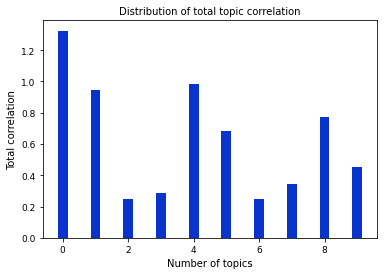

In [215]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [
    [ "quality",'product'],
    ["delivery",'time'],
    [ "service",'seller'],
    ['price','worth'],
    ['return', 'exchange','problem'],
    ['schedule','deadline','delay'],
    ['thank'],
    ['package','condition'],
    ['recommend'],
    ['defect','defective']
    
]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=10, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=3 # Tell the model how much it should rely on the anchors
)
print(model.tc)

plt.figure(figsize=(6,4))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#0833CD', width=0.3)
plt.tick_params(axis='both', which='major', labelsize=9);
plt.title('Distribution of total topic correlation', fontsize=10)
plt.xlabel('Number of topics', fontsize=10)
plt.ylabel('Total correlation', fontsize=10)
plt.savefig('10_anchor_better.png', dpi=300, bbox_inches='tight');

In [214]:
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["topic_{}".format(i+1) for i in range(10)]
).astype(float)
topic_df.index = df_trans_review.index
df = pd.concat([df_trans_review, topic_df], axis=1)
df['topic_coverage']=df['topic_1']+df['topic_2']+df['topic_3']+df['topic_4']+df['topic_5']+df['topic_6']+df['topic_7']+df['topic_8']+df['topic_9']+df['topic_10']#+df['topic_11']+df['topic_12']+df['topic_13']+df['topic_14']+df['topic_15']+df['topic_16']+df['topic_17']
df['topic_coverage'].value_counts()

1.0    13192
2.0    11683
0.0     8696
3.0     5824
4.0     1906
5.0      372
6.0       49
7.0        4
Name: topic_coverage, dtype: int64

In [216]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=20)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: product, quality, excellent, advertise, poor, correct, describe, expect, exactly, correspond, correctly, specifications, characteristics, gorgeous, accord, accordance, specify
Topic #2: delivery, time, fast, long, speed, always, record, shorter, forecast, period, limit, faster, early, consume, efficient, slow, quick, surprise, confusion, anticipate
Topic #3: service, seller, provide, attentive, provision, level, prompt, promptly, sales, hemo, juice, lemon, solenoid, pitch, npt, guava, rage, reassure, miserable, grape
Topic #4: price, worth, beautiful, little, material, cost, think, benefit, find, size, look, photo, small, thin, like, finish, leave, fabric, bigger, better
Topic #5: return, problem, exchange, buy, one, receive, post, send, office, two, pay, already, order, wait, purchase, make, contact, want, far, would
Topic #6: deadline, schedule, delay, arrive, well, ahead, deliver, stipulate, date, establish, estimate, meet, within, past, congratulate, tbm, initial, navigat

6.342059831651707


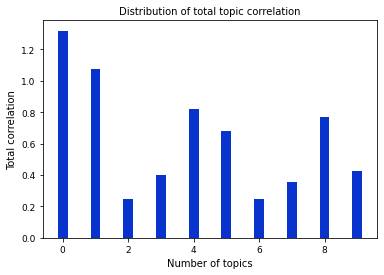

In [229]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [ 
      [ "quality",'product'],
    ["delivery",'fast','time'],
       [ "service",'seller'],
    ['price','worth','value'],
    ['return', 'exchange'], 
    ['delay','schedule','deadline'],
    ['thank','grateful'],
     ['package','condition'],
       ['recommend'],
    ['defect','defective','problem']
]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=10, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=3 # Tell the model how much it should rely on the anchors
)
print(model.tc)

plt.figure(figsize=(6,4))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#0833CD', width=0.3)
plt.tick_params(axis='both', which='major', labelsize=9);
plt.title('Distribution of total topic correlation', fontsize=10)
plt.xlabel('Number of topics', fontsize=10)
plt.ylabel('Total correlation', fontsize=10)
plt.savefig('10_anchor_best.png', dpi=300, bbox_inches='tight');

In [230]:
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["topic_{}".format(i+1) for i in range(10)]
).astype(float)
topic_df.index = df_trans_review.index
df = pd.concat([df_trans_review, topic_df], axis=1)
df['topic_coverage']=df['topic_1']+df['topic_2']+df['topic_3']+df['topic_4']+df['topic_5']+df['topic_6']+df['topic_7']+df['topic_8']+df['topic_9']+df['topic_10']#+df['topic_11']+df['topic_12']+df['topic_13']+df['topic_14']+df['topic_15']+df['topic_16']+df['topic_17']
df['topic_coverage'].value_counts()

1.0    12986
2.0    11536
0.0     8381
3.0     6023
4.0     2250
5.0      484
6.0       62
7.0        4
Name: topic_coverage, dtype: int64

In [231]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=20)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: product, quality, advertise, poor, correct, describe, expect, exactly, correspond, correctly, specifications, characteristics, gorgeous, accord, accordance, specify, malfunction
Topic #2: delivery, time, fast, long, efficient, speed, record, shorter, period, limit, early, faster, consume, surprise, slow, agile, quick, agility, mega, anticipate
Topic #3: service, seller, provide, attentive, provision, level, prompt, promptly, sales, grape, lime, miserable, npt, pitch, solenoid, juice, rage, bsp, reassure, hemo
Topic #4: price, worth, value, beautiful, little, box, small, material, cost, think, look, photo, cover, size, find, benefit, finish, plastic, fit, thin
Topic #5: return, one, receive, buy, exchange, two, send, order, already, wait, pay, want, another, contact, purchase, make, far, come, would, email
Topic #6: deadline, schedule, delay, arrive, well, ahead, deliver, stipulate, date, establish, estimate, meet, within, past, tbm, initial, fetch, navigation
Topic #7: thank,

7.230865812119786


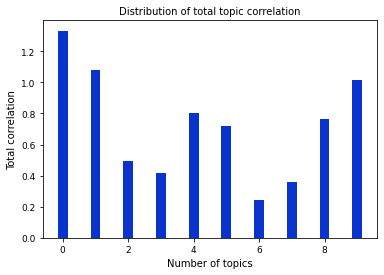

In [261]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [ 
   [ "quality",'product','advertise','describe','expect'],
    ["delivery",'fast','time','speed'],
    [ "service",'seller','store'],
    ['price','worth','value','cost'],
    ['receive','return', 'exchange'], 
    ['deadline','schedule','delay','date','estimate'],
    ['thank','grateful','merry'],
     ['package','condition'],
       ['recommend'],
    ['defect','defective','problem']
    
]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=10, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=3 # Tell the model how much it should rely on the anchors
)
print(model.tc)

plt.figure(figsize=(6,4))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#0833CD', width=0.3)
plt.tick_params(axis='both', which='major', labelsize=9);
plt.title('Distribution of total topic correlation', fontsize=10)
plt.xlabel('Number of topics', fontsize=10)
plt.ylabel('Total correlation', fontsize=10)
plt.savefig('10_anchor_best.png', dpi=300, bbox_inches='tight');

In [279]:
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["topic_{}".format(i+1) for i in range(10)]
).astype(float)
topic_df.index = df_trans_review.index
df = pd.concat([df_trans_review, topic_df], axis=1)
df['topic_coverage']=df['topic_1']+df['topic_2']+df['topic_3']+df['topic_4']+df['topic_5']+df['topic_6']+df['topic_7']+df['topic_8']+df['topic_9']+df['topic_10']#+df['topic_11']+df['topic_12']+df['topic_13']+df['topic_14']+df['topic_15']+df['topic_16']+df['topic_17']
df['topic_coverage'] = df['topic_coverage'].astype(int)
df['topic_coverage'].value_counts()

2    11766
1    11614
0     7520
3     7111
4     2818
5      758
6      117
7       21
8        1
Name: topic_coverage, dtype: int64

In [259]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=20)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: product, quality, advertise, describe, excellent, expect, poor, correct, exactly, correspond, test, specifications, correctly, characteristics, arrival, accordance, gorgeous
Topic #2: delivery, time, fast, speed, long, efficient, record, shorter, forecast, period, limit, early, consume, faster, surprise, right, slow, agile, quick, confusion
Topic #3: store, service, seller, shop, customer, always, provide, online, trust, attentive, american, best, congratulate, customers, physical, reliable, responsible, deadlines, lousy, provision
Topic #4: price, worth, value, cost, beautiful, little, material, photo, think, small, look, size, benefit, cover, find, finish, fit, color, thin, plastic
Topic #5: receive, return, exchange, yet, request, goods, evaluate, guidance, moment, att, notification, sender, chandeliers, procom, october, scholarship, bucket, armrest
Topic #6: deadline, schedule, date, delay, arrive, well, ahead, estimate, deliver, stipulate, establish, pass, meet, within, 

7.096087423067129


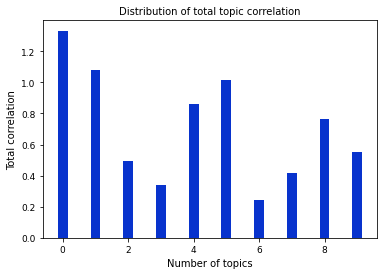

In [378]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [ 
   [ "quality",'product','advertise','describe','expect'],
    ["delivery",'fast','time','speed'],
    [ "service",'seller','store'],
    ['price','worth','value','cost'],
    ['return', 'exchange','refund','cancel'], 
    ['deadline','schedule','delay','arrive'],
    ['thank','grateful','merry'],
     ['package','condition','box'],
       ['recommend'],
    ['problem','wrong','defect','defective']
    
]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=10, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=3 # Tell the model how much it should rely on the anchors
)
print(model.tc)

plt.figure(figsize=(6,4))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#0833CD', width=0.3)
plt.tick_params(axis='both', which='major', labelsize=9);
plt.title('Distribution of total topic correlation', fontsize=10)
plt.xlabel('Number of topics', fontsize=10)
plt.ylabel('Total correlation', fontsize=10)
plt.savefig('10_anchor_best.png', dpi=300, bbox_inches='tight');

In [379]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=20)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: product, quality, advertise, describe, deliver, expect, poor, correct, exactly, meet, correspond, test, specifications, within, characteristics, accordance, gorgeous
Topic #2: delivery, time, fast, speed, long, efficient, record, shorter, period, limit, early, consume, faster, surprise, slow, agile, quick, agility, mega, anticipate
Topic #3: store, service, seller, shop, customer, always, provide, online, trust, attentive, american, best, congratulate, customers, physical, reliable, responsible, deadlines, lousy, provision
Topic #4: price, worth, value, cost, beautiful, little, material, benefit, think, size, find, look, small, finish, photo, thin, fabric, like, bigger, better
Topic #5: return, cancel, exchange, receive, one, buy, two, refund, send, already, order, wait, purchase, pay, make, contact, want, far, email, would
Topic #6: arrive, deadline, schedule, well, ahead, date, stipulate, right, estimate, establish, earlier, quickly, correctly, sooner, intact, past, neatly,

In [380]:
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["topic_{}".format(i+1) for i in range(10)]
).astype(float)
topic_df.index = df_trans_review.index
df = pd.concat([df_trans_review, topic_df], axis=1)
df['topic_coverage']=df['topic_1']+df['topic_2']+df['topic_3']+df['topic_4']+df['topic_5']+df['topic_6']+df['topic_7']+df['topic_8']+df['topic_9']+df['topic_10']#+df['topic_11']+df['topic_12']+df['topic_13']+df['topic_14']+df['topic_15']+df['topic_16']+df['topic_17']
df['topic_coverage'] = df['topic_coverage'].astype(int)
df['topic_coverage'].value_counts()

1    12173
2    11225
0     7872
3     6756
4     2758
5      800
6      127
7       14
8        1
Name: topic_coverage, dtype: int64

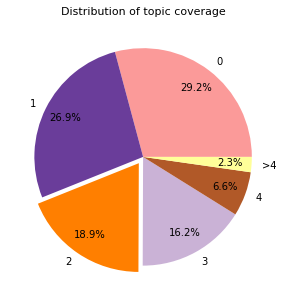

In [381]:
import pylab
df['topic_coverage'].values[df['topic_coverage'] > 5] = 5
fig, ax =plt.subplots(1,1,figsize=(5,5))
cmap = plt.get_cmap("Paired")
explode = (0, 0 ,0.07 ,0, 0, 0,)
df['topic_coverage'].value_counts().plot.pie(colors=cmap(np.array([4,9,7,8,11,10])), labels=['0','1','2','3','4','>4'],
                                             explode=explode, autopct='%1.1f%%', pctdistance=0.8);
plt.title('Distribution of topic coverage', fontsize=11)
plt.tick_params(axis='both', which='major', labelsize=9)
pylab.ylabel('')
#plt.xticklabels(['0','1','2','3','4','>4'])
plt.savefig('topic-coverage.png', dpi=300, bbox_inches='tight');

In [400]:
from corextopic import vis_topic as vt
vt.vis_rep(model, column_label=vocab, prefix='10anchor_models')

df.to_csv("final_topic_prediction.csv", header=True, index=False)

df_final = pd.read_csv("final_topic_prediction.csv")
df_CorEx=df_final[['review_comment_en','review_score','topic_1', 'topic_2', 
                  'topic_3', 'topic_4', 'topic_5', 'topic_6','topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_coverage']]

df_CorEx.columns = ['review_comment', 'review_score', 'product_quality', 'fast_delivery', 'seller/store_service',
                    'price_value','return_cancel_exchange','deadline_schedule','thank_grateful','package_condition','recommend',
                    'problem_wrong_defective','topic_coverage']

Print topics in text file


In [85]:
df_final = pd.read_csv("final_topic_prediction.csv")
df_CorEx=df_final[['review_comment_en','review_score','topic_1', 'topic_2', 
                  'topic_3', 'topic_4', 'topic_5', 'topic_6','topic_7', 'topic_8', 'topic_9', 'topic_10']]

df_CorEx.columns = ['review_comment', 'review_score', 'product quality advertise',' delivery time fast','store service seller','price worth value','return cancel exchange',
 'arrive deadline schedule', 'thank grateful much', 'package condition box', 'recommend highly everyone', 
 'problem wrong come']


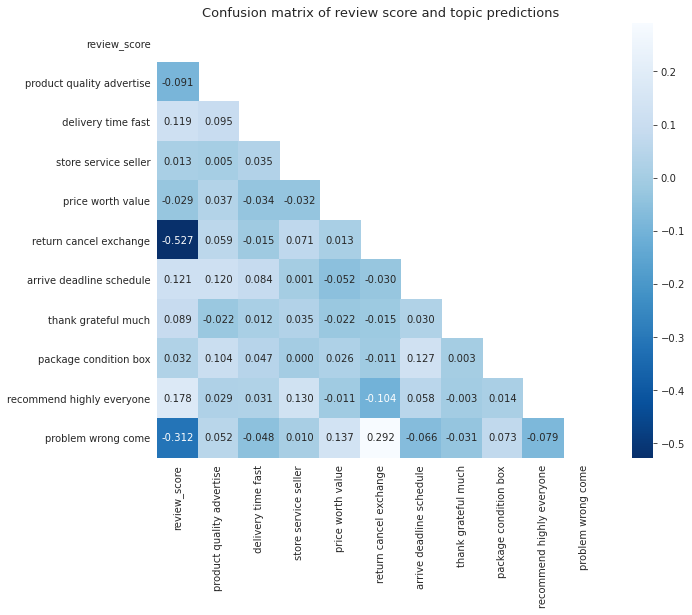

In [97]:
corr1= df_CorEx.corr()
mask = np.zeros_like(corr1) 
mask[np.triu_indices_from(corr1)] = True 
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(corr1, mask=mask, annot=True, fmt=".3f", cmap= 'Blues_r') 
#plt.xticks(rotation=80);
plt.title('Confusion matrix of review score and topic predictions', fontsize=13);
plt.savefig('Corex-corr.png', dpi=300, bbox_inches='tight');

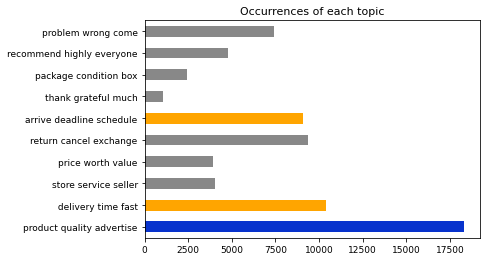

In [83]:
df_sum = pd.DataFrame(df_CorEx,columns=['product quality advertise',' delivery time fast','store service seller','price worth value','return cancel exchange',
 'arrive deadline schedule', 'thank grateful much', 'package condition box', 'recommend highly everyone', 
 'problem wrong come'])
fig, ax =plt.subplots(1,1,figsize=(6,4))
cmap = plt.get_cmap("Paired")
#plt.legend(loc="right", fontsize=9)

ax = df_sum.sum().plot(kind='barh', color = '#0833CD', legend=False) #labels=label_list,# autopct='%1.1f%%', pctdistance=0.8, 
                  #colors=cmap(np.arange(10)),fontsize=9)
#barlist[0].set_color('r')
plt.title('Occurrences of each topic', fontsize=11);
#ax = df.plot(kind='barh', color=colors, legend=False)

for bar in ax.patches:
    bar.set_facecolor('#888888')

#highlight = 'product quality advertise'
pos = df_sum.sum().index.get_loc('product quality advertise')

ax.patches[pos].set_facecolor('#0833CD')
ax.tick_params(axis='both', which='major', labelsize=9)


pos = df_sum.sum().index.get_loc(' delivery time fast')
ax.patches[pos].set_facecolor('orange')

pos = df_sum.sum().index.get_loc('arrive deadline schedule')
ax.patches[pos].set_facecolor('orange')
plt.savefig('topics.png', dpi=300, bbox_inches='tight');

In [397]:
# df_b = df_CorEx.sample(15)
# df_b

# df_b.to_csv('sample.csv', header=True, index=True)

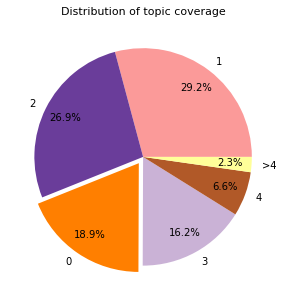

In [16]:
import pylab
df_CorEx['topic_coverage'].values[df_CorEx['topic_coverage'] > 5] = 5
fig, ax =plt.subplots(1,1,figsize=(5,5))
cmap = plt.get_cmap("Paired")
explode = (0, 0 ,0.07 ,0, 0, 0,)
df_CorEx['topic_coverage'].value_counts().plot.pie(colors=cmap(np.array([4,9,7,8,11,10])), labels=['1','2','0','3','4','>4'],
                                             explode=explode, autopct='%1.1f%%', pctdistance=0.8);
plt.title('Distribution of topic coverage', fontsize=11)
plt.tick_params(axis='both', which='major', labelsize=9)
pylab.ylabel('')
#plt.xticklabels(['0','1','2','3','4','>4'])
plt.savefig('topic-coverage.png', dpi=300, bbox_inches='tight');

### Sentiment prediction

#### BOW method for creating classifiers 

The premise of a BOW(bag-of-words model) is to take a collection of "documents" (the corpus, which can be sentences, paragraphs, or any other string that can occupy an index in a list) and convert them to a "bag" of frequency counts for each "word" encountered in the corpus. The end result is a list of lists, vectors, which can then be passed through a machine learning classifier.  Tutorial link: https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
bow = vectorizer.fit_transform(df_trans_review['review_step_5'])
labels = df_trans_review['label_positive']

# see how many unique words (features) within all the reviews
len(vectorizer.get_feature_names())

7492

In [8]:
# remove words which appear very infrequently in the dataset, less than 2 times
vectorizer = TfidfVectorizer(min_df=2)
bow = vectorizer.fit_transform(df_trans_review['review_step_5'])
len(vectorizer.get_feature_names())

3966

In [8]:
# from sklearn.feature_selection import SelectKBest, chi2

# # select 4000 features that have the strongest correlation to a class from the remaining 4197 features.
# #selected_features = SelectKBest(chi2, k=5000).fit(bow, labels).get_support(indices=True)

# vectorizer = TfidfVectorizer(min_df=2, vocabulary=selected_features)

# bow = vectorizer.fit_transform(df_trans_review['review_step_5'])
# bow

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bow, labels, test_size=0.3, random_state=48)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(max_iter=200)
log_model = clf_log.fit(X_train, y_train)
# Compute the accuracy scores of different folds in training data
scores_log = cross_val_score(clf_log, X_train, y_train, cv=10) 
scores_log.mean()

0.8712679322618919

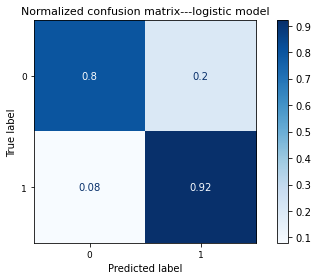

In [12]:
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
title = "Normalized confusion matrix---logistic model"
disp = plot_confusion_matrix(clf_log, X_test, y_test, 
                             display_labels=y_test.unique(), 
                             cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title(title, fontsize=11)
disp.ax_.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()   
#plt.title('Distribution of feature importance', fontsize=11)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight');
plt.show();

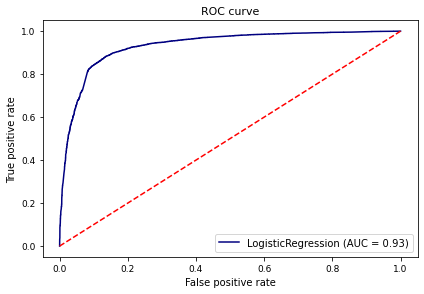

In [13]:
# # ROC curve
from sklearn.metrics import plot_roc_curve
          # Plot classifier ROC
ax = plt.gca()
rfc_disp = plot_roc_curve(clf_log, X_test, y_test, ax=ax, alpha=1.0, color='navy') #log_disp = plot_roc_curve(clf_log, test_x, test['successful_artist'], ax=ax, alpha=0.8)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()   
plt.title('ROC curve', fontsize=11)
plt.xlabel('False positive rate',fontsize=10)
plt.ylabel('True positive rate',fontsize=10)
plt.savefig('ROC.png', dpi=300, bbox_inches='tight');
plt.show();

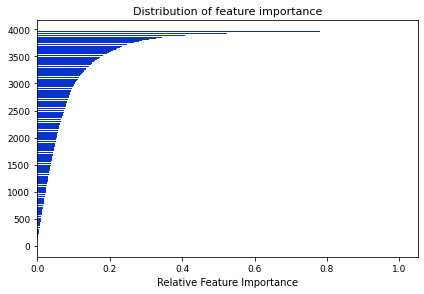

In [14]:
feature_importance = abs(clf_log.coef_[0])
feature_importance =(feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure(figsize=(6,4))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='#0833CD')
#featax.set_yticks(pos)
#featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance', fontsize=10)
featax.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()   
plt.title('Distribution of feature importance', fontsize=11)
plt.savefig('feature importance.png', dpi=300, bbox_inches='tight');
plt.show();

In [19]:
# Get top 20 important features 
coefs=clf_log.coef_[0]
top_20 = np.argpartition(coefs, -20)[-20:]
bottom_20 = np.argpartition(coefs, 20)[:20]
t = vectorizer.get_feature_names()
Top_20_pos = [t[i] for i in top_20]
Top_20_neg = [t[i] for i in bottom_20]
Top_20_pos
Top_20_neg

['congratulate',
 'thank',
 'perfect',
 'love',
 'excellent',
 'time',
 'right',
 'wonderful',
 'perfectly',
 'easy',
 'deadline',
 'fast',
 'congratulations',
 'everything',
 'well',
 'satisfy',
 'ahead',
 'beautiful',
 'quickly',
 'test']

['receive',
 'defective',
 'disappoint',
 'pass',
 'dissatisfy',
 'bad',
 'return',
 'poor',
 'low',
 'terrible',
 'far',
 'today',
 'wait',
 'expire',
 'different',
 'refund',
 'break',
 'await',
 'solution',
 'cancel']